# 导包

In [1]:
import torch
import torchvision
import torch.nn
import torch.nn.init
import torch.utils.data as data
# print(torch.__version__)
# print(torchvision.__version__)
# print(torch.cuda.is_available())
import numpy as np
import random
import time
import math

In [2]:
import basic
import data
import nlp

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
(corpus_indices, char_to_idx, idx_to_char, vocab_size) = data.load_data_jay_lyrics()

# RNN
- 循环神经网络基础推荐视频[同济子豪兄的B站视频](https://www.bilibili.com/video/av86713932/?p=9)
- 推荐学习资料(知乎高赞)：[LSTM知乎高赞文章](https://zhuanlan.zhihu.com/p/32085405)

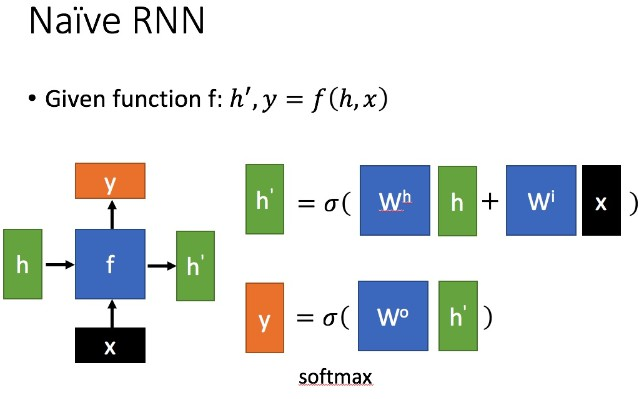

In [5]:
def one_hot(x, n_class, dtype=torch.float32):
    """
    对一维特征进行独热编码。

    :param x:类别标签向量（batch_size,1）或者（batch_size,）
    :param n_class:类别数量
    :param dtype:
    :return:独热编码矩阵（batch_size, n_class)
    """
    x = x.long()
    res = torch.zeros(x.shape[0], n_class, dtype=dtype, device=x.device)
    res.scatter_(1, x.view(-1, 1), 1)
    return res

In [6]:
x = torch.tensor([0, 2])
xx = one_hot(x, 10)

In [7]:
x.shape, xx.shape

(torch.Size([2]), torch.Size([2, 10]))

In [8]:
def to_onehot(X, n_class):
    """
    对时间序列数据进行独热编码，可以作为RNN模型的输入。

    :param X: 采样后的时序数据，(batch, seq_len)。
    :param n_class: 类别数量。
    :return: seq_len elements of (batch, n_class)
    """
    return [one_hot(X[:, i], n_class) for i in range(X.shape[1])]

In [9]:
X = torch.arange(10).view(2, 5)
inputs = to_onehot(X, vocab_size)
print(len(inputs), inputs[0].shape)

5 torch.Size([2, 1027])


## 初始化
$${H}_t = \phi({X}_t {W}_{xh} + {H}_{t-1} {W}_{hh}  + {b}_h)$$

## 模型参数

In [10]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size

In [11]:
def get_params(num_inputs, num_hiddens, num_outputs):
    """
    初始化深RNN的模型参数。

    :param num_inputs:输入特征数量。
    :param num_hiddens: 隐藏状态特征数量。
    :param num_outputs: 输出特征数量
    :return:
    """
    def _one(shape):
        ts = torch.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=torch.float32)
        return torch.nn.Parameter(ts, requires_grad=True)
    W_xh = _one((num_inputs, num_hiddens))
    W_hh = _one((num_hiddens, num_hiddens))
    b_h = torch.nn.Parameter(torch.zeros(num_hiddens, device=device, requires_grad=True))
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device, requires_grad=True))
    return torch.nn.ParameterList([W_xh, W_hh, b_h, W_hq, b_q])

## 初始隐藏状态

In [12]:
def init_rnn_state(batch_size, num_hiddens, device):
    return torch.zeros((batch_size, num_hiddens), device=device),

## 定义模型

In [13]:
def rnn(inputs, state, params):
    """
    RNN网络前向步进运算。

    :param inputs: num_steps个形状为(batch_size, vocab_size)。
    :param state: 模型隐藏状态的初始值。
    :param params: RNN网络参数，W_xh, W_hh, b_h, W_hq, b_q。
    :return: num_steps个形状为(batch_size, vocab_size)
    """
    # inputs和outputs皆为num_steps个形状为(batch_size, vocab_size)的矩阵
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
#         print(H.shape, X.shape, W_xh.shape, H.shape, W_hh.shape, b_h.shape)
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)

In [14]:
state = init_rnn_state(X.shape[0], num_hiddens, device)
inputs = to_onehot(X.to(device), vocab_size)
params = get_params(num_inputs, num_hiddens, num_outputs)

In [15]:
params

ParameterList(
    (0): Parameter containing: [torch.cuda.FloatTensor of size 1027x256 (GPU 0)]
    (1): Parameter containing: [torch.cuda.FloatTensor of size 256x256 (GPU 0)]
    (2): Parameter containing: [torch.cuda.FloatTensor of size 256 (GPU 0)]
    (3): Parameter containing: [torch.cuda.FloatTensor of size 256x1027 (GPU 0)]
    (4): Parameter containing: [torch.cuda.FloatTensor of size 1027 (GPU 0)]
)

In [16]:
outputs, state_new = rnn(inputs, state, params)
print(len(outputs), outputs[0].shape, state_new[0].shape) 

5 torch.Size([2, 1027]) torch.Size([2, 256])


## 定义预测函数
训练时和应用时的`batch_size`、`step_nums`可以不一样。
![RNN结构示例](http://zh.gluon.ai/_images/rnn-train.svg)

In [17]:
def predict_rnn(prefix, num_chars, rnn, params, init_rnn_state,
                num_hiddens, vocab_size, device, idx_to_char, char_to_idx):
    """
    基于RNN模型继续补全句子，一次输入一个字符，预测一个字符，因此batch_size=1，step_num=1。

    :param prefix: 起始输入序列，未预处理。
    :param num_chars: 预测长度。
    :param rnn: RNN模型。
    :param params: RNN模型参数。
    :param init_rnn_state: 模型隐藏层初始状态。
    :param num_hiddens: 隐藏单元数量。
    :param vocab_size: 语料库大小。
    :param device: GPU/CPU。
    :param idx_to_char: list。
    :param char_to_idx: dict。
    :return: 输出序列。
    """
    state = init_rnn_state(1, num_hiddens, device)
    output = [char_to_idx[prefix[0]]]
    for t in range(num_chars + len(prefix) - 1):
        # X是step_nums个(batch, n_class)组成的列表。
        X = to_onehot(torch.tensor([[output[-1]]], device=device), vocab_size)
        (Y, state) = rnn(X, state, params)
        # 下一个时间步的输入是prefix里的字符或者当前的最佳预测字符
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            output.append(int(Y[0].argmax(dim=1).item()))
    return ''.join([idx_to_char[i] for i in output])

In [18]:
predict_rnn('分开', 10, rnn, params, init_rnn_state, num_hiddens, vocab_size,
            device, idx_to_char, char_to_idx)

'分开弥怀方柳有纳甩缘辛状'

## 梯度裁剪
RNN容易出现梯度衰减或者梯度爆炸,梯度裁剪可以应对梯度爆炸。

1. 求所有的模型参数梯度的范数
2. 检测范数是否超过阈值
3. 归一化到小于阈值theta

$$
 \min\left(\frac{\theta}{\|{g}\|}, 1\right){g}
$$

In [19]:
def grad_clipping(params, theta, device):
    """
    梯度裁剪，对所有的模型参数一起裁剪。

    :param params: 模型参数。
    :param theta: 阈值。
    :param device: CPU/GPU。
    :return: 裁剪后的模型参数。
    """
    norm = torch.tensor([0.0], device=device)
    for param in params:
        norm += (param.grad.data ** 2).sum()
    norm = norm.sqrt().item()
    if norm > theta:
        for param in params:
            param.grad.data *= (theta / norm)

## 困惑度

困惑度是对交叉熵损失函数做指数运算后得到的值。

- 最佳情况下，模型总是把标签类别的概率预测为1，此时困惑度为1；
- 最坏情况下，模型总是把标签类别的概率预测为0，此时困惑度为正无穷；
- 基线情况下，模型总是预测所有类别的概率都相同，此时困惑度为类别个数。
- 任何一个有效模型的困惑度必须小于类别个数。在本例中，困惑度必须小于词典大小vocab_size。

## 训练模型
RNN自动作词。

- 用困惑度评价模型，评价指标与损失函数不同，本初损失函数仍然是交叉熵。
- 在迭代模型参数前裁剪梯度；
- 不同的采样方法会导致不同的隐藏状态初始化。
    - 相邻采样在epoch开始时初始化隐藏状态
    - 随机采样在每个小批量更新前初始化隐藏状态
- 相邻采样为了避免模型参数的梯度多次计算，梯度计算开销太大，使用detach函数从计算图分离隐藏状态。

In [20]:
def train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, is_random_iter, num_epochs, num_steps,
                          lr, clipping_theta, batch_size, pred_period,
                          pred_len, prefixes):
    """
    RNN模型的训练和预测，RNN模型训练和应用时的batch_size，step_nums不一样。
    应用时batch_size=1，step_nums=1。

    :param rnn: RNN模型。
    :param get_params: 模型参数。
    :param init_rnn_state: 隐藏层初始状态。
    :param num_hiddens: 隐藏状态特征数量。
    :param vocab_size: 语料库大小。
    :param device: CPU/GPU。
    :param corpus_indices: 时序数据列表。
    :param idx_to_char: list。
    :param char_to_idx: dict。
    :param is_random_iter: 随机采样/相邻采样。
    :param num_epochs:
    :param num_steps: 时间步长=1。
    :param lr: 学习率。
    :param clipping_theta: 梯度裁剪阈值。
    :param batch_size: 批大小。
    :param pred_period: 预测的epochs间隔。
    :param pred_len: 预测长度。
    :param prefixes: 提词。
    :return: None
    """
    if is_random_iter:
        data_iter_fn = nlp.data_iter_random
    else:
        data_iter_fn = nlp.data_iter_consecutive
    params = get_params(num_inputs, num_hiddens, num_outputs)
    loss = torch.nn.CrossEntropyLoss()

    count = 0
    for epoch in range(num_epochs):
        if not is_random_iter:  # 如使用相邻采样，在epoch开始时初始化隐藏状态
            state = init_rnn_state(batch_size, num_hiddens, device)
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_fn(corpus_indices, batch_size, num_steps, device)
        for X, Y in data_iter:
            if is_random_iter:  # 如使用随机采样，在每个小批量更新前初始化隐藏状态
                state = init_rnn_state(batch_size, num_hiddens, device)
            else:
            # 否则需要使用detach函数从计算图分离隐藏状态, 这是为了使模型参数
            # 的梯度计算只依赖一次迭代读取的小批量序列(防止梯度计算开销太大)
                for s in state:
                    s.detach_()

            inputs = to_onehot(X, vocab_size)
            # outputs有num_steps个形状为(batch_size, vocab_size)的矩阵
            "print(count,len(inputs),inputs[0].shape)"
            count += 1
            (outputs, state) = rnn(inputs, state, params)
            # 拼接之后形状为(num_steps * batch_size, vocab_size)
            outputs = torch.cat(outputs, dim=0)
            # Y的形状是(batch_size, num_steps)，转置后再变成长度为
            # num_steps*batch 的向量，这样跟输出的行一一对应
            y = torch.transpose(Y, 0, 1).contiguous().view(-1)
            # 使用交叉熵损失计算平均分类误差

            l = loss(outputs, y.long())
            # 梯度清0
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params, clipping_theta, device)  # 裁剪梯度
            basic.sgd(params, lr, 1)  # 因为误差已经取过均值，梯度不用再做平均

            l_sum += l.item() * y.shape[0]
            n += y.shape[0]

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn(prefix, pred_len, rnn, params, init_rnn_state,
                    num_hiddens, vocab_size, device, idx_to_char, char_to_idx))

## 运用模型预测

In [21]:
(corpus_indices, char_to_idx, idx_to_char, vocab_size) = data.load_data_jay_lyrics()
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
num_epochs, num_steps, batch_size, lr, clipping_theta = 250, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']

In [22]:
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, False, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)

epoch 50, perplexity 64.002263, time 0.27 sec
 - 分开 我想你的可爱女人的透 我不要这爱 我不要再不 我不能你不 我不能你不 我不能你不 我不能你不 我不
 - 不分开 我想你的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏
epoch 100, perplexity 7.647359, time 0.29 sec
 - 分开 一颗在 旧颗她颗停留 所有人 瞎不了 什么都有  如一直热昏 一人在人不的公瓣还 我有著这 你小村
 - 不分开觉 你 在直胸口 快果我有轻功 飞檐走壁 为人用双截棍 哼哼哈兮 快使用双截棍 哼哼哈兮 快使用双截
epoch 150, perplexity 2.122625, time 0.27 sec
 - 分开 小养我 说你就那手 巫师 他念里 干词的 像酋长暴诅咒  我穿了其 我想在你熬 你不人事抽离 如果
 - 不分开觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生
epoch 200, perplexity 1.303054, time 0.30 sec
 - 分开 小候我 谁是我 难你的河面的我 别子抖我满腔的怒火鸠 平愿像猫的狗 印地安老斑鸠 平常话不多 除非
 - 不分开觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生
epoch 250, perplexity 1.162407, time 0.28 sec
 - 分开 问候我 在是神枪手 巫师 他念念 有词的 对酋长下诅咒 还我骷髅头 这故事 告诉我 印地安的传说 
 - 不分开觉 你已经离是我 不知不觉 我跟了这节奏 后知后觉 又知了一个秋 后知后觉 我该好好生活 我该好好生


In [23]:
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, True, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)

epoch 50, perplexity 65.364724, time 0.27 sec
 - 分开 我不要再想你 我爱你这 你你的外 在谁了外 你的让空 我不定 别怪我 一子四 一颗两 三颗四 一颗
 - 不分开 爱你的让我疯疼的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱女人 坏坏的让我疯狂的可爱
epoch 100, perplexity 9.997386, time 0.27 sec
 - 分开 一直两步三 四步盘 旧皮空 装颗四三信过的 干什么 干什么 干颗四三都过的 干什么 干什么 干颗四
 - 不分开吗 我不能再想 我不 我不 我不要再想 我不 我不 我不要再想 我不 我不 我不要再想 我不 我不 
epoch 150, perplexity 2.841305, time 0.28 sec
 - 分开 一直两步三步 篮管毛不多 除非是人难过 它伤妙 娘子她人在江南等望著天 看星星 一颗两颗三颗四颗 
 - 不分开吗 我不能再 你打我外 这样耿直 你有没用 恨一场空 不敢不同 你一场空 说一不中 你一场 废么走囱
epoch 200, perplexity 1.592905, time 0.28 sec
 - 分开 那想就开乡打的雨 随时准备重袭让我的道 相地的色斑人 我狠狠忘国 你是三我的证据 让晶莹的泪滴 闪
 - 不分开期 然后将过去 慢慢温习 温暖完外屋 白色蜡烛 温暖了空屋 白色蜡烛 温暖了空屋 白色蜡烛 温暖了空
epoch 250, perplexity 1.314217, time 0.28 sec
 - 分开 一直都是 大的完两 每你跟同 你给没空 你都没空 说我不懂 说了再用 他的笑容 过我不懂 说一场用
 - 不分开扫 然后将过去 慢慢温习 让我爱上你 那场悲剧 是你完美演出的一场戏 宁愿心碎哭泣 再狠狠忘记 你爱


# GRU

## RNN的缺陷
LSTM和GRU主要是用来解决循环神经网络中梯度消失和梯度爆炸问题提出来，并且还具有保留长的历史信息的功能。它们都是基于门控的RNN，而门控可以简单的理解为对本来没有门控的输入每个元素乘上了一个0-1的权重，进行有选择性的忘记和记忆，这样就可以在有限的记忆容量(我们可以认为参数的最大容量)下记住更加重要的信息，而忘记不重要的信息，虽然GRU没有和LSTM一样的遗忘门和输入门，但是它的重置门和更新门也可以起到选择性的忘记与记忆的功能。

首先回顾一下普通的RNN的结构，如下图所示(台大李宏毅的PPT中的内容)，从图中可以看出，普通的RNN的输入部分有上一时间步的隐藏状态$h$和当前时间步的输入$x$两部分组成，而输出部分由当前时间步的隐藏状态h'和输出y组成，具体与参数及激活函数的关系可以从图中直接看出，对普通的RNN结构就先放这里,用于对LSTM和GRU的结构进行对比的

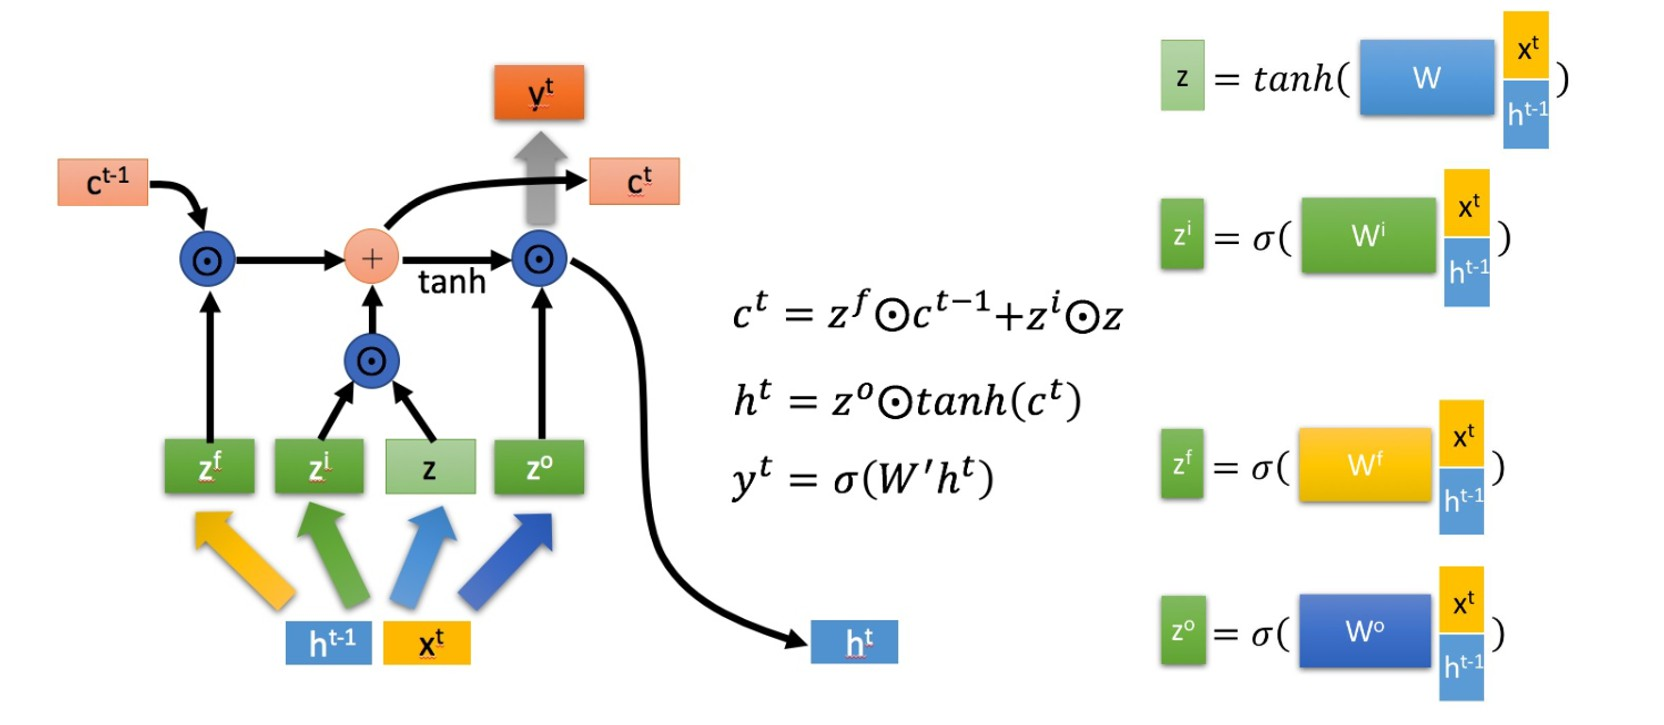

# LSTM


# 深度循环神经网络